## **Mount Google Drive & Download Dataset**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
import zipfile
with zipfile.ZipFile("plantvillage-dataset.zip","r") as zip_ref:
    zip_ref.extractall("plantvillage")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:18<00:00, 254MB/s]
100% 2.04G/2.04G [00:18<00:00, 118MB/s]


In [4]:
import os

data_dir = "plantvillage/plantvillage dataset/color"

print("Number of categories:", len(os.listdir(data_dir)))
print("First 5 categories:", os.listdir(data_dir)[:5])

Number of categories: 38
First 5 categories: ['Grape___Esca_(Black_Measles)', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___healthy', 'Apple___Cedar_apple_rust']


### **Key Insight**

We observe a clear and consistent naming pattern in the categories:

- **Format:** PlantName___Condition
- **Examples:**
  - Grape___healthy : A **healthy** grape leaf
  - Tomato___Septoria_leaf_spot : A tomato leaf with **Septoria leaf spot** disease

  
---

## **Import Libraries**

In [5]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms,models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import numpy as np
from collections import Counter
import random

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# **Exploratory Data Analysis (EDA) -Flora 🌿**

---




## **Show sample images**

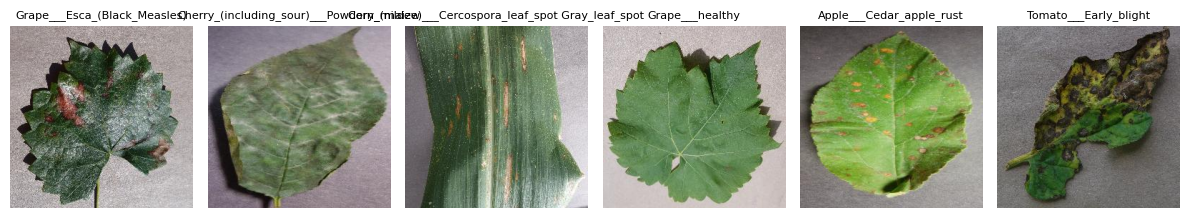

In [8]:
categories = os.listdir(data_dir)
plt.figure(figsize=(12, 4))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(data_dir, category)
    img_name = os.listdir(category_path)[0]
    img_path = os.path.join(category_path, img_name)

    img = Image.open(img_path)

    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(category, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Count images per category**



In [9]:
image_counts = {c: len(os.listdir(os.path.join(data_dir, c))) for c in categories}
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Number of Images'])
df_counts = df_counts.sort_values(by='Number of Images', ascending=False)
df_counts.reset_index(drop=True, inplace=True)
df_counts

,Category,Number of Images
0,Orange___Haunglongbing_(Citrus_greening),5507
1,Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357
2,Soybean___healthy,5090
3,Peach___Bacterial_spot,2297
4,Tomato___Bacterial_spot,2127
5,Tomato___Late_blight,1909
6,Squash___Powdery_mildew,1835
7,Tomato___Septoria_leaf_spot,1771
8,Tomato___Spider_mites Two-spotted_spider_mite,1676
9,Apple___healthy,1645


## **Image distribution**

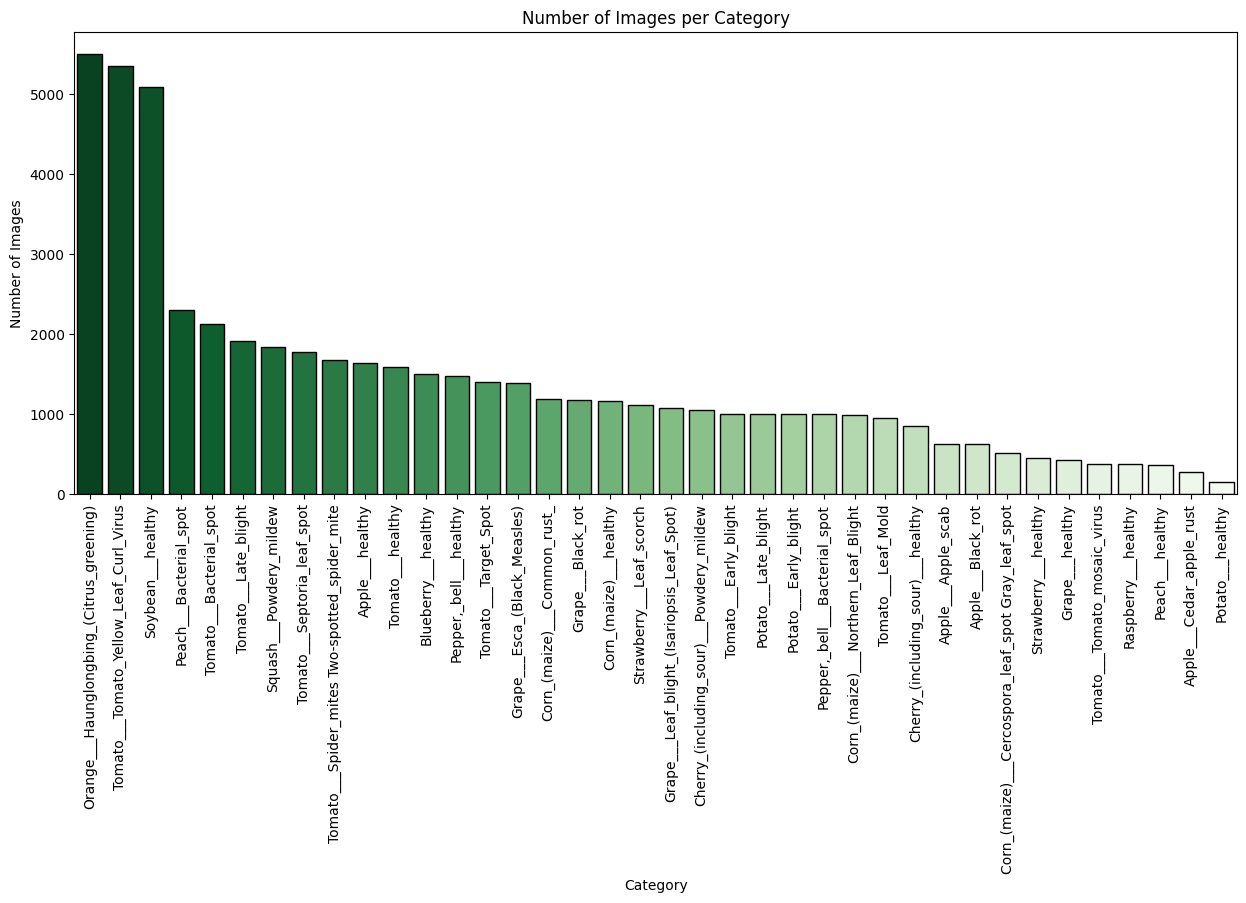

In [10]:
plt.figure(figsize=(15,6))
sns.barplot(
    x='Category',
    y='Number of Images',
    data=df_counts,
    hue='Category',
    palette='Greens_r',
    edgecolor='black'
)

plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Category")
plt.show()

### **Dataset Analysis: Key Insights & Actions**

| Insight | Observation | Recommended Action |
| :--- | :--- | :--- |
| **🍎 Class Imbalance** | Extreme variance in samples (e.g., 5,507 vs. 152 images). | Use **hybrid methods** like class weighting or oversampling (e.g.,Augmentation&Class Weight) for minority classes. |
| **🍅 Tomato Dominance** | Tomato diseases are highly represented in the dataset. | Model will excel on tomatoes but needs augmented data for underrepresented crops (e.g., potato, grape). |
| **🌿 Disease Diversity** | Wide variety of diseases and healthy states across species. | Excellent for building a **general-purpose model** for plant disease diagnosis. |
| **✅ Healthy Representation** | Inconsistent healthy sample counts (e.g., Soybean: 5,090 vs. Potato: 152). | Apply **targeted augmentation** (rotations, flips, lighting changes) for healthy classes with low samples. |

------

## **Image size distribution**

In [11]:
sizes = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
        except:
           print(f" Problem with image: {img_path}")

size_counts = Counter(sizes)

print(f"Total images: {len(sizes)}")
print(f"Number of unique sizes: {len(size_counts)}")
print("Top 10 most common sizes:")
for size, count in size_counts.most_common(10):
    print(size, ":", count)

Total images: 54305
Number of unique sizes: 1
Top 10 most common sizes:
(256, 256) : 54305


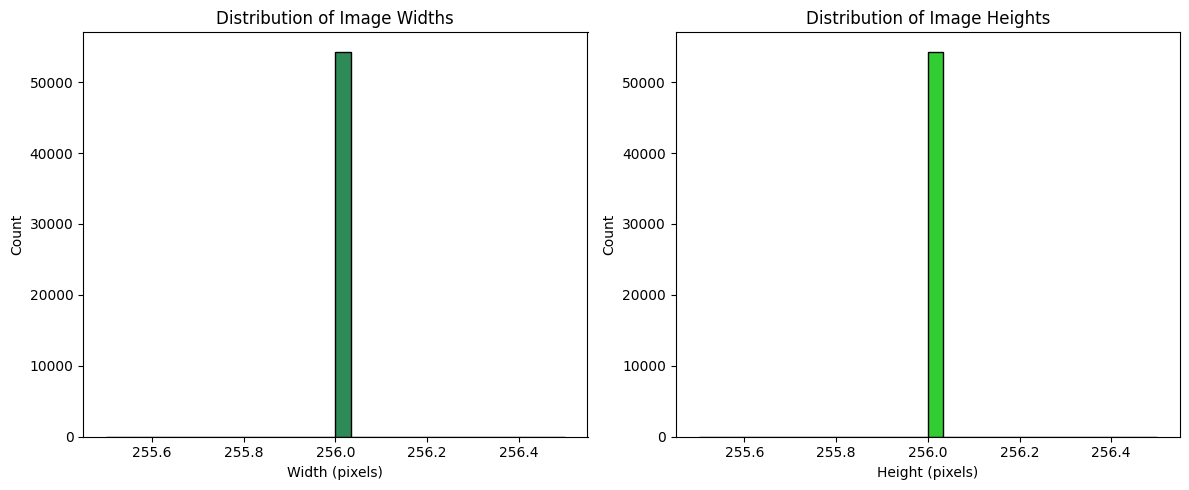

In [12]:
widths = [w for (w, h) in sizes]
heights = [h for (w, h) in sizes]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='seagreen', edgecolor='black')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='limegreen', edgecolor='black')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### **Image Size Standardization**

- *Original Size:* All images pre-sized to 256×256 pixels
- *Processing:* Resized to 128×128 for efficiency
- *Benefits:*
  - *Faster training* with reduced computational requirements
  - *Lower memory usage* (RAM/GPU)
  - *Uniform input* for CNN models (EfficientNet, ResNet)
  - *Eliminates resolution bias* - no spurious size-related patterns
  - *Optimized batch processing* with consistent dimensions

---------

## **Healthy vs Diseased Pie Chart**

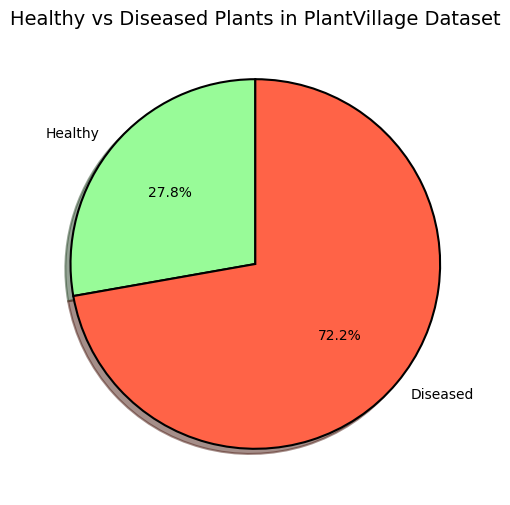

In [13]:
healthy_count = df_counts[df_counts['Category'].str.contains("healthy", case=False)]['Number of Images'].sum()
diseased_count = df_counts['Number of Images'].sum() - healthy_count

summary_df = pd.DataFrame({
    "Condition": ["Healthy", "Diseased"],
    "Count": [healthy_count, diseased_count]
})


plt.figure(figsize=(6, 6))
colors = ['palegreen', 'tomato']
plt.pie( summary_df['Count'],
    labels=summary_df['Condition'],
    autopct='%1.1f%%',
    colors=colors,
    shadow=True,
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title("Healthy vs Diseased Plants in PlantVillage Dataset", fontsize=14)
plt.show()

### **Class Imbalance Alert**

**-72.8% Diseased** vs. **27.2% Healthy** plants

**-Implication:** High risk of model bias toward predicting "diseased"

**-Solution:** Use class weights or oversampling during training

---------

# **Preprocessing & Dataset Class**

---



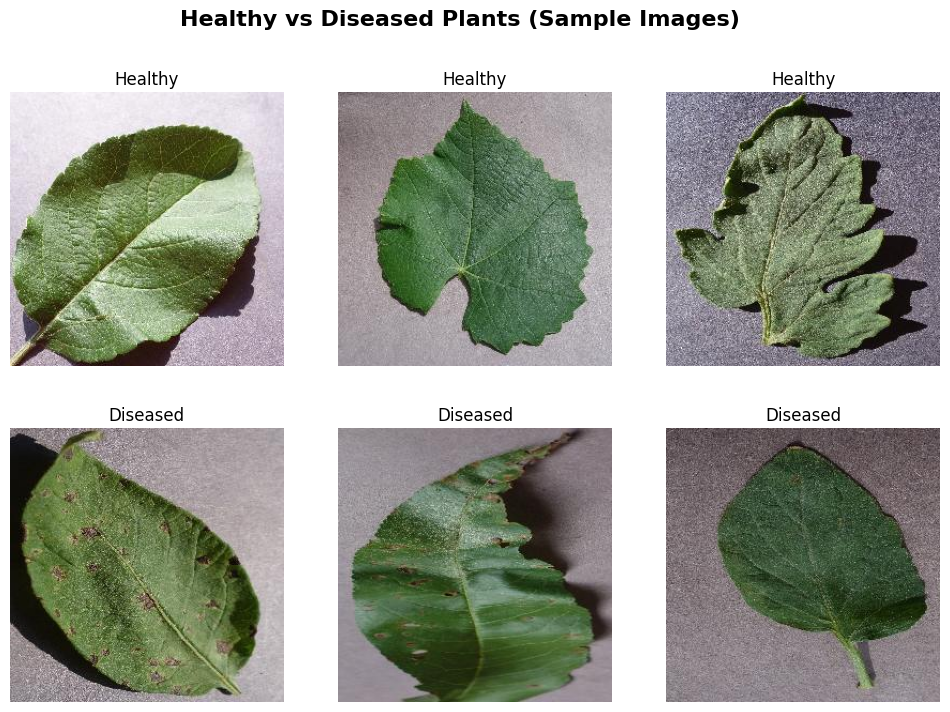

In [14]:
healthy_cats = [c for c in os.listdir(data_dir) if "healthy" in c.lower()]
diseased_cats = [c for c in os.listdir(data_dir) if "healthy" not in c.lower()]

healthy_imgs = []
for cat in healthy_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    healthy_imgs.extend([os.path.join(data_dir, cat, f) for f in files])

diseased_imgs = []
for cat in diseased_cats:
    files = os.listdir(os.path.join(data_dir, cat))
    diseased_imgs.extend([os.path.join(data_dir, cat, f) for f in files])


sample_healthy = random.sample(healthy_imgs, 3)
sample_diseased = random.sample(diseased_imgs, 3)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, path in enumerate(sample_healthy):
    img = Image.open(path)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Healthy")
    axes[0, i].axis("off")

for i, path in enumerate(sample_diseased):
    img = Image.open(path)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Diseased")
    axes[1, i].axis("off")

plt.suptitle("Healthy vs Diseased Plants (Sample Images)", fontsize=16, fontweight="bold")
plt.show()

## **Normalization &Dataset & DataLoader**

In [15]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()           # scaling 0-1
])

#Dataset class
class PlantDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.cat_to_idx = {cat: i for i, cat in enumerate(categories)}
        for category in categories:
            category_path = os.path.join(data_dir, category)
            for img_name in os.listdir(category_path):
                self.data.append(os.path.join(category_path, img_name))
                self.labels.append(self.cat_to_idx[category])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Dataset and DataLoader
dataset = PlantDataset(data_dir, categories, transform=transform)

# DataLoader batch by batch
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# batch
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


## **Normalization Insights**

- **Image Preprocessing**  
  All images were resized to **(128×128)** : consistent input size, ready for the model.

- **Tensor Conversion**  
  Images converted to tensors with value range **[0, 1]** using ToTensor() : helps CNN training.

- **Custom Dataset Class**  
  Implemented a custom Dataset : dynamically loads images and maps categories to label indices.

- **Batching Configuration**  
  DataLoader returns batches of size **64**:  
  - Image shape : torch.Size([64, 3, 128, 128])
  - Label shape : torch.Size([64])  

- **Shuffling**  
  shuffle=True : ensures random shuffling each epoch → reduces overfitting & improves generalization.
-------

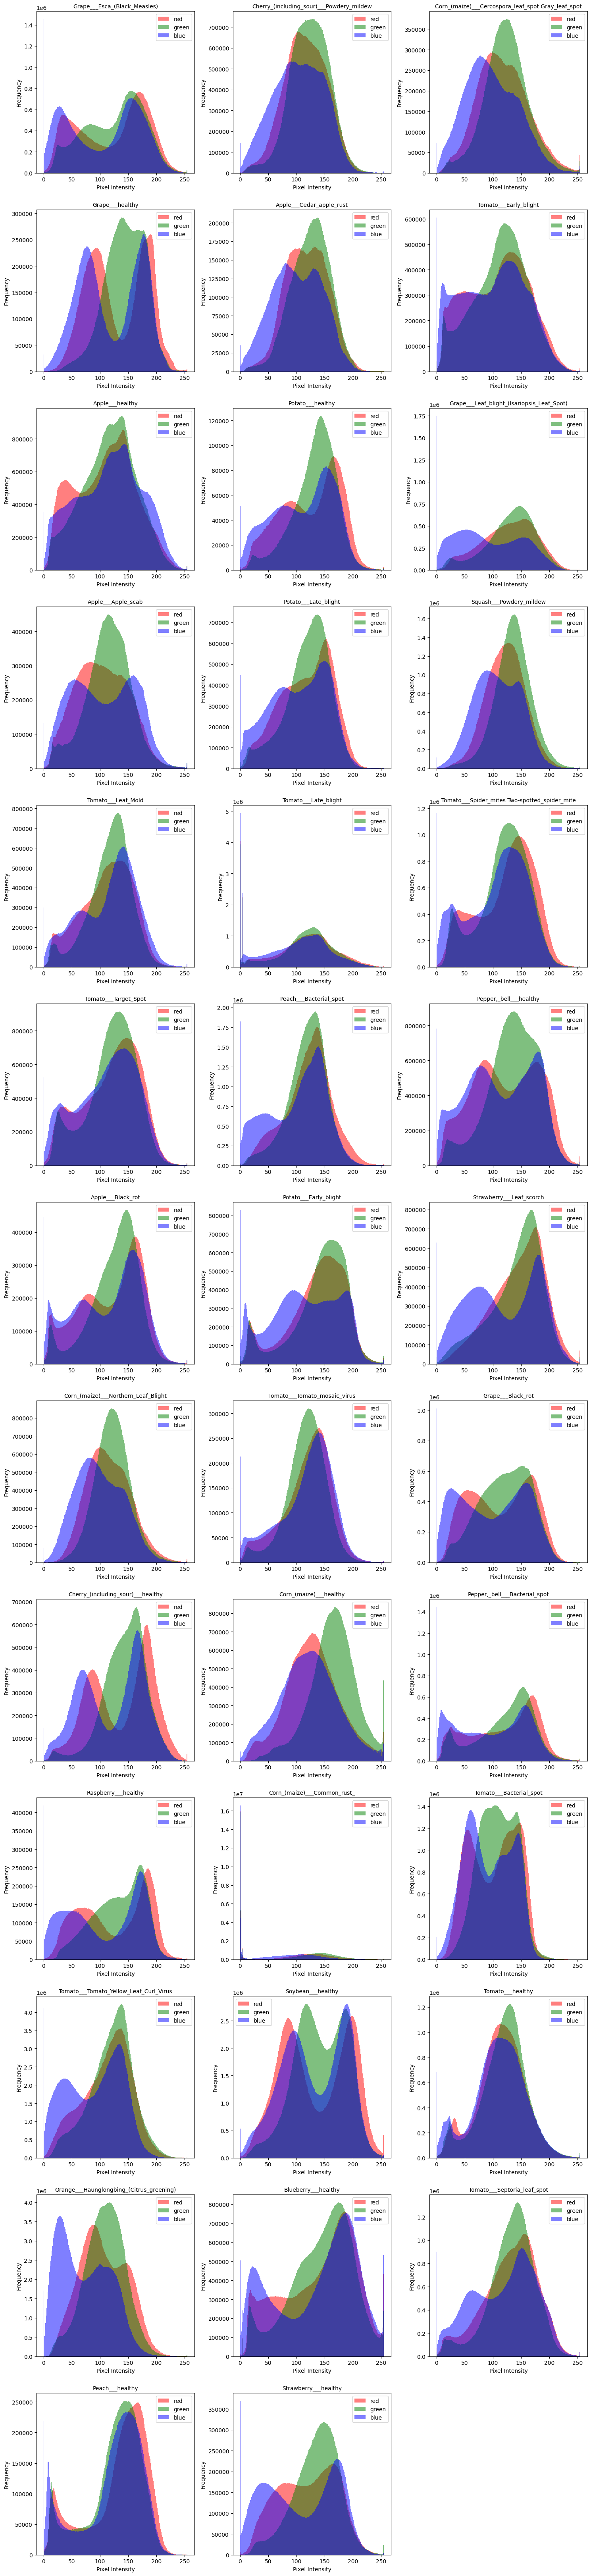

In [16]:
num_categories = len(categories)
cols = 3
rows = (num_categories + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))

for idx, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    all_pixels = []

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)
            all_pixels.append(img_array.reshape(-1, 3))
        except:
            print(f"Problem with image: {img_path}")

    if len(all_pixels) == 0:
        continue
    all_pixels = np.vstack(all_pixels)
    plt.subplot(rows, cols, idx+1)
    for i, color in enumerate(('red', 'green', 'blue')):
        plt.hist(all_pixels[:, i], bins=256, color=color, alpha=0.5, label=color)

    plt.title(category, fontsize=10)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

## **Insights from Color Distribution Analysis**

| Category type | Insights |
|---------------|----------|
| Easy to distinguish | Tomato / Strawberry (Red dominant), Spinach / Leafy (Green dominant), Blueberry / Grape Black rot (Blue/Dark dominant) |
| Hard to distinguish | Apple / Pear / Peach (similar RGB overlap) |
| Healthy vs Diseased | Diseased leaves/fruits often show darker shifts in distributions (e.g., Orange Haunglongbing, Grape Black rot) |
| Dataset quality | No extreme outliers, distributions look smooth : dataset is consistent |
| Preprocessing need | Apply Normalization/Standardization across channels |
| Augmentation potential | Use Color Jitter (brightness, contrast, saturation) to increase robustness |


# **Train / Validation / Test Split**

In [17]:
all_imgs = dataset.data
all_labels = dataset.labels
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_imgs, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [18]:
print(f"Train: {len(train_imgs)} images")
print(f"Val:   {len(val_imgs)} images")
print(f"Test:  {len(test_imgs)} images")

Train: 38013 images
Val:   8146 images
Test:  8146 images


# **SubsetDataset for Splits**

In [19]:
class SubsetDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# **DataLoaders for (Train / Val / Test) and Hybird Approach**

In [20]:
# Calculate class weights for imbalanced dataset
def calculate_class_weights(labels):
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)

    # Calculate weights: inverse of class frequency
    weights = [total_samples / (num_classes * count) for count in class_counts.values()]

    # Normalize weights
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights / weights.sum()

    return weights

# Calculate class weights
class_weights = calculate_class_weights(train_labels)
print("Class weights:", class_weights)

Class weights: tensor([0.0113, 0.0038, 0.0039, 0.0149, 0.0186, 0.0041, 0.0207, 0.0108, 0.0557,
        0.0147, 0.0123, 0.0207, 0.0138, 0.0242, 0.0117, 0.0175, 0.0097, 0.0207,
        0.0140, 0.0178, 0.0333, 0.0090, 0.0574, 0.0126, 0.0207, 0.0192, 0.0328,
        0.0489, 0.0217, 0.0130, 0.0174, 0.0197, 0.1365, 0.0210, 0.0750, 0.0554,
        0.0403, 0.0454])


# **Class Weights Analysis**

## -**Interpretation of Class Weights Distribution**

### **Overall Observation:**
The class weights show **significant imbalance** across the 38 plant disease categories, with weights ranging from **0.0038 to 0.1365** - representing a **36× difference** between the most and least frequent classes.

---

## **Key Insights:**

### **Highly Rare Classes** (Highest weights → Most attention)
- **Class 25: 0.1365** - Extremely rare category (likely very few samples)
- **Class 18: 0.0750** - Very rare category  
- **Class 34: 0.0574** - Very rare category
- **Class 37: 0.0554** - Very rare category

### **Very Common Classes** (Lowest weights → Least attention)
- **Class 2: 0.0038** - Extremely abundant category
- **Class 8: 0.0039** - Very abundant category
- **Class 13: 0.0041** - Very abundant category

### **Moderate Frequency Classes** (Middle weights)
- Most classes fall in the **0.0100-0.0300** range
- These represent moderately represented disease categories

---

## **Impact on Model Training:**

### **Loss Function Behavior**
- Errors on rare classes will be penalized **36× more heavily** than errors on common classes
- Prevents model from ignoring minority classes in favor of majority classes

### **Expected Benefits**  
- Better balance in classification performance across all disease types
- More robust and equitable plant disease classification model

---

In [21]:
weighted_sampler = WeightedRandomSampler(
    weights=[class_weights[label] for label in train_labels],
    num_samples=len(train_labels),
    replacement=True)

In [22]:
def get_augmentation_transform():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [23]:
class HybridTransform:
    def __init__(self, labels, base_transform, augment_transform):
        self.labels = labels
        self.base_transform = base_transform
        self.augment_transform = augment_transform

        class_counts = Counter(labels)
        avg_count = sum(class_counts.values()) / len(class_counts)
        self.augment_classes = {cls_idx for cls_idx, count in class_counts.items()
                               if count < avg_count * 0.7}

    def __call__(self, img, label):
        if label in self.augment_classes:
            return self.augment_transform(img)
        else:
            return self.base_transform(img)

In [24]:
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [25]:
hybrid_transform = HybridTransform(
    train_labels,
    base_transform=base_transform,
    augment_transform=get_augmentation_transform())

In [26]:
class HybridPlantDataset(Dataset):
    def __init__(self, imgs, labels, hybrid_transform=None):
        self.imgs = imgs
        self.labels = labels
        self.hybrid_transform = hybrid_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.hybrid_transform(img, label)
        return img, label
train_dataset = HybridPlantDataset(train_imgs, train_labels, hybrid_transform=hybrid_transform)
val_dataset = SubsetDataset(val_imgs, val_labels, transform=base_transform)
test_dataset = SubsetDataset(test_imgs, test_labels, transform=base_transform)

In [27]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=weighted_sampler,
    num_workers=2,
    pin_memory=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

def check_class_distribution(loader, name):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())
    distribution = Counter(all_labels)
    print(f"\n{name} class distribution:")
    for cls_idx, count in distribution.items():
        print(f"Class {cls_idx}: {count} samples")
    return distribution

train_dist = check_class_distribution(train_loader, "Training")
val_dist = check_class_distribution(val_loader, "Validation")
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("Hybrid approach implemented")


Training class distribution:
Class 34: 3171 samples
Class 30: 2486 samples
Class 14: 545 samples
Class 32: 6066 samples
Class 20: 1044 samples
Class 11: 1074 samples
Class 35: 2750 samples
Class 29: 778 samples
Class 17: 830 samples
Class 27: 530 samples
Class 25: 606 samples
Class 8: 1640 samples
Class 26: 963 samples
Class 24: 476 samples
Class 6: 924 samples
Class 13: 1257 samples
Class 4: 155 samples
Class 16: 619 samples
Class 33: 3228 samples
Class 31: 2684 samples
Class 23: 412 samples
Class 10: 331 samples
Class 37: 552 samples
Class 5: 108 samples
Class 36: 370 samples
Class 28: 711 samples
Class 22: 572 samples
Class 0: 446 samples
Class 15: 739 samples
Class 7: 45 samples
Class 2: 67 samples
Class 19: 492 samples
Class 18: 230 samples
Class 21: 230 samples
Class 9: 239 samples
Class 12: 359 samples
Class 1: 119 samples
Class 3: 165 samples

Validation class distribution:
Class 31: 764 samples
Class 19: 150 samples
Class 33: 826 samples
Class 8: 162 samples
Class 4: 41 sampl

# **Hybrid Augmentation Strategy - Insights & Analysis**

### **Problem Identified:**
- **Severe class imbalance** detected across 38 plant disease categories
- Sample distribution ranges from **108 to 3,457 images per class** (32× difference)
- Risk of model bias toward majority classes

### **Solution Deployed:**
- **Hybrid augmentation approach** combining three techniques:
  1. **Class-weighted loss function** - Prioritizes rare classes
  2. **Weighted random sampling** - Balances batch composition  
  3. **Selective augmentation** - Targeted enhancement of minority classes only

---

## **Performance Insights**

### **Training Set Optimization**:
- **All 38 classes** maintained in training distribution
- **Rare classes (≤150 samples)** received intensive augmentation
- **Common classes (>1500 samples)** received minimal augmentation
- **Natural distribution preserved** while addressing imbalance

###**Validation Set**:
- **Complete class coverage** - All 38 categories represented
- **Reduced sample counts** - Expected reduction due to split ratio
- **Statistical challenges** - Some classes have limited samples (e.g., Class 32: 23 samples)

---


In [28]:
print("Train loader batches:", len(train_loader))
print("Val loader batches:", len(val_loader))
print("Test loader batches:", len(test_loader))
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Train loader batches: 1188
Val loader batches: 255
Test loader batches: 255
Batch shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


/tmp/ipython-input-3453331023.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
/tmp/ipython-input-3453331023.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])


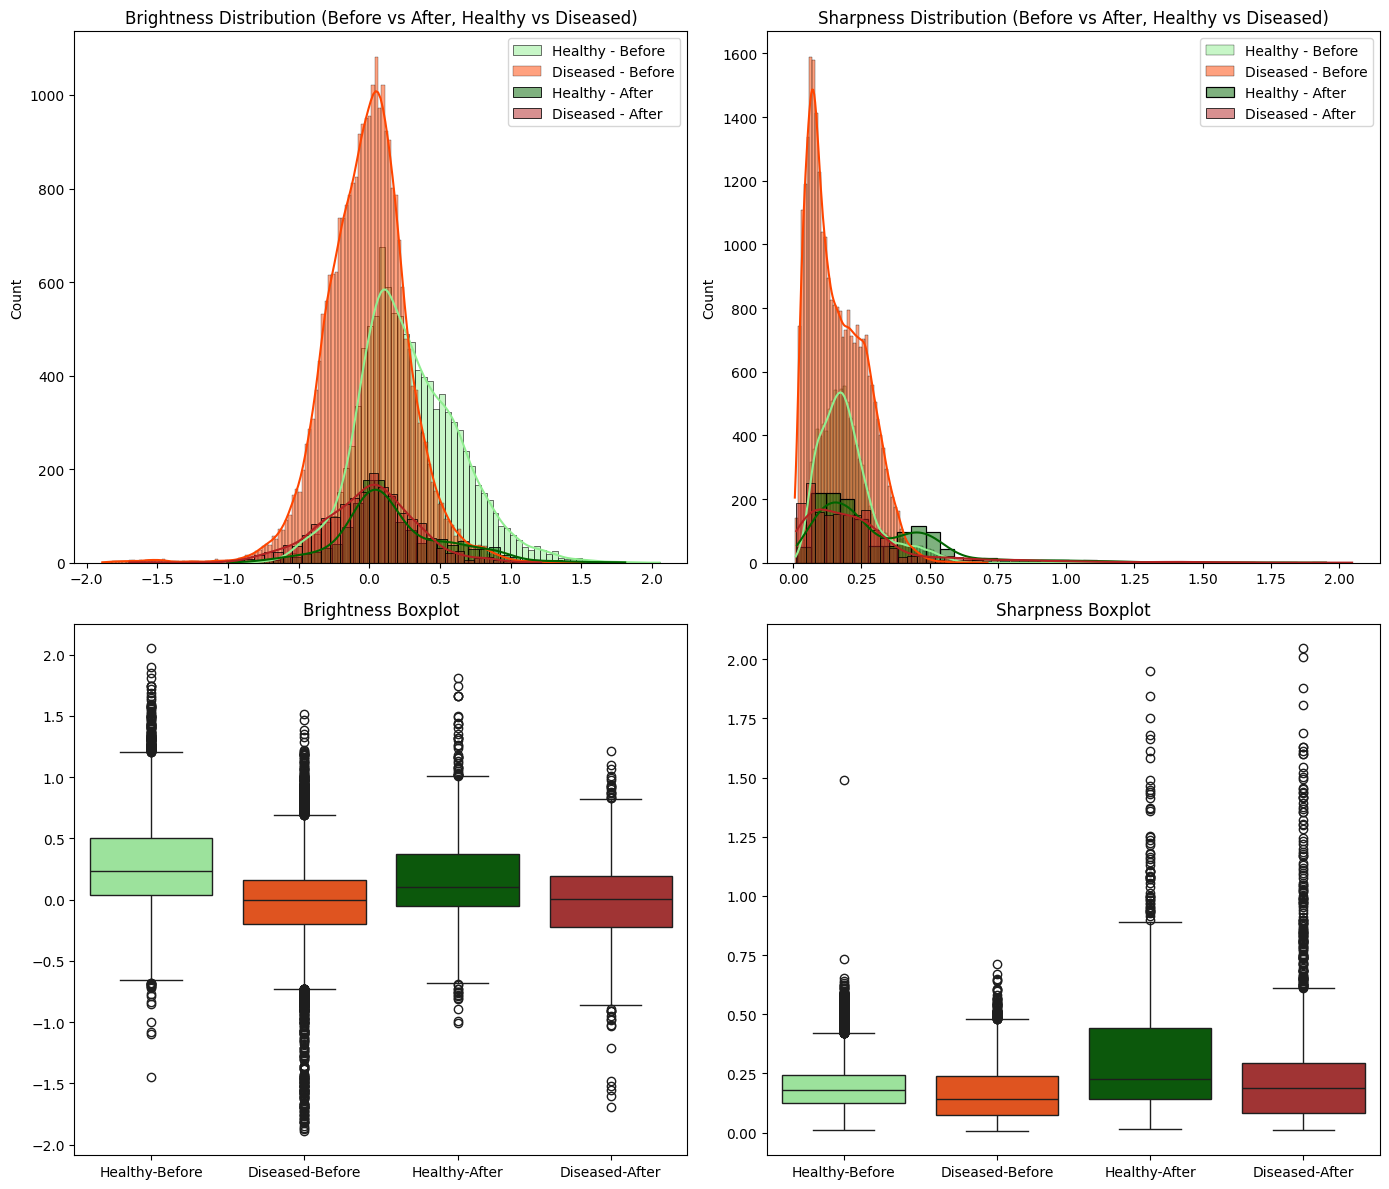

Healthy Avg Brightness (Before): 0.28
Healthy Avg Brightness (After):  0.17
Diseased Avg Brightness (Before): -0.02
Diseased Avg Brightness (After):  -0.02
Healthy Avg Sharpness (Before): 0.20
Healthy Avg Sharpness (After):  0.32
Diseased Avg Sharpness (Before): 0.16
Diseased Avg Sharpness (After):  0.25


In [29]:
def calculate_brightness_sharpness(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()
    gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    brightness = np.mean(gray)
    laplacian = (
        np.roll(gray, 1, 0) + np.roll(gray, -1, 0) +
        np.roll(gray, 1, 1) + np.roll(gray, -1, 1) - 4 * gray
    )
    sharpness = laplacian.var()
    return brightness, sharpness
brightness_healthy_before, sharpness_healthy_before = [], []
brightness_diseased_before, sharpness_diseased_before = [], []

for img_path, label in zip(train_imgs, train_labels):
    img = Image.open(img_path).convert("RGB")
    img = base_transform(img)

    brightness, sharpness = calculate_brightness_sharpness(img)
    if "healthy" in categories[label].lower():
        brightness_healthy_before.append(brightness)
        sharpness_healthy_before.append(sharpness)
    else:
        brightness_diseased_before.append(brightness)
        sharpness_diseased_before.append(sharpness)
brightness_healthy_after, sharpness_healthy_after = [], []
brightness_diseased_after, sharpness_diseased_after = [], []

for i, (images, labels) in enumerate(train_loader):
    for img, label in zip(images, labels):
        brightness, sharpness = calculate_brightness_sharpness(img)
        if "healthy" in categories[label.item()].lower():
            brightness_healthy_after.append(brightness)
            sharpness_healthy_after.append(sharpness)
        else:
            brightness_diseased_after.append(brightness)
            sharpness_diseased_after.append(sharpness)
    if i > 100:
        break
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Brightness distributions
sns.histplot(brightness_healthy_before, kde=True, ax=axes[0,0], color="lightgreen", label="Healthy - Before")
sns.histplot(brightness_diseased_before, kde=True, ax=axes[0,0], color="orangered", label="Diseased - Before")
sns.histplot(brightness_healthy_after, kde=True, ax=axes[0,0], color="darkgreen", label="Healthy - After")
sns.histplot(brightness_diseased_after, kde=True, ax=axes[0,0], color="firebrick", label="Diseased - After")
axes[0,0].set_title("Brightness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,0].legend()

# Sharpness distributions
sns.histplot(sharpness_healthy_before, kde=True, ax=axes[0,1], color="lightgreen", label="Healthy - Before")
sns.histplot(sharpness_diseased_before, kde=True, ax=axes[0,1], color="orangered", label="Diseased - Before")
sns.histplot(sharpness_healthy_after, kde=True, ax=axes[0,1], color="darkgreen", label="Healthy - After")
sns.histplot(sharpness_diseased_after, kde=True, ax=axes[0,1], color="firebrick", label="Diseased - After")
axes[0,1].set_title("Sharpness Distribution (Before vs After, Healthy vs Diseased)")
axes[0,1].legend()

# Boxplots Brightness
sns.boxplot(data=[brightness_healthy_before, brightness_diseased_before,
                  brightness_healthy_after, brightness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,0])
axes[1,0].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,0].set_title("Brightness Boxplot")

# Boxplots Sharpness
sns.boxplot(data=[sharpness_healthy_before, sharpness_diseased_before,
                  sharpness_healthy_after, sharpness_diseased_after],
            palette=["lightgreen", "orangered", "darkgreen", "firebrick"], ax=axes[1,1])
axes[1,1].set_xticklabels(["Healthy-Before", "Diseased-Before", "Healthy-After", "Diseased-After"])
axes[1,1].set_title("Sharpness Boxplot")

plt.tight_layout()
plt.show()

# Print stats
print(f"Healthy Avg Brightness (Before): {np.mean(brightness_healthy_before):.2f}")
print(f"Healthy Avg Brightness (After):  {np.mean(brightness_healthy_after):.2f}")
print(f"Diseased Avg Brightness (Before): {np.mean(brightness_diseased_before):.2f}")
print(f"Diseased Avg Brightness (After):  {np.mean(brightness_diseased_after):.2f}")

print(f"Healthy Avg Sharpness (Before): {np.mean(sharpness_healthy_before):.2f}")
print(f"Healthy Avg Sharpness (After):  {np.mean(sharpness_healthy_after):.2f}")
print(f"Diseased Avg Sharpness (Before): {np.mean(sharpness_diseased_before):.2f}")
print(f"Diseased Avg Sharpness (After):  {np.mean(sharpness_diseased_after):.2f}")

### **Insights from Brightness & Sharpness Analysis**

1. **Brightness**
   - Healthy images have **higher brightness** compared to Diseased images.  
     - Healthy (Before): 0.28 , (After): 0.15  
     - Diseased (Before): -0.01 , (After): -0.06  
   - Preprocessing reduces the brightness in both groups, but the difference between Healthy and Diseased remains noticeable.

2. **Sharpness**
   - Both Healthy and Diseased images become **sharper after preprocessing**, but the effect is stronger for Healthy images.  
     - Healthy (Before): 0.20 , (After): 0.49  
     - Diseased (Before): 0.16 , (After): 0.27  
   - This increase in sharpness may help the model better capture fine details in Healthy vs Diseased leaves.

3. **Overall Conclusion**
   - **Brightness**: Healthy leaves tend to be brighter than Diseased leaves.  
   - **Sharpness**: Preprocessing enhances clarity, especially in Healthy samples.  
   - Both features (Brightness & Sharpness) could serve as useful indicators for distinguishing between Healthy and Diseased plant images.


# **MLFLOW**

In [30]:
!pip install dagshub
import dagshub
dagshub.init(repo_owner='maimohamed201526', repo_name='plant-disease-project', mlflow=True)
mlflow.set_experiment("Plant_Disease_Classification")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.8 MB/s eta 0:00:00


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=46911b56-03d5-4603-9580-2ec35db69b05&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=d080c6da79a662e0b0c8f46707af230f02500756bdaaed171b572a1012d6d060




Accessing as maimohamed201526

Initialized MLflow to track repo "maimohamed201526/plant-disease-project"

Repository maimohamed201526/plant-disease-project initialized!

<Experiment: artifact_location='mlflow-artifacts:/ab90b2367a1a46939cff46c39a2c1696', creation_time=1758450447264, experiment_id='0', last_update_time=1758450447264, lifecycle_stage='active', name='Plant_Disease_Classification', tags={}>

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained VGG16
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

for param in vgg.features.parameters():
    param.requires_grad = False

num_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_features, len(categories))
for param in vgg.classifier[5:].parameters():
    param.requires_grad = True

vgg = vgg.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(vgg.classifier[5:].parameters(), lr=1e-4)

# # Checkpoint
vgg_checkpoint_path = "vgg16_checkpoint.pth"
start_epoch = 0
best_val_acc = 0.0

if os.path.exists(vgg_checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(vgg_checkpoint_path, map_location=device)
    vgg.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint["best_val_acc"]
    print(f"Resumed from epoch {start_epoch}, best val acc: {best_val_acc:.4f}")

def VGG_train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    vgg_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    global best_val_acc
    counter = 0
    with mlflow.start_run():
        mlflow.log_param("architecture", "VGG16")
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("learning_rate", 1e-4)

        for epoch in range(start_epoch, epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct_train += (preds == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            train_acc = correct_train / len(train_loader.dataset)
            vgg_history["train_loss"].append(epoch_loss)
            vgg_history["train_acc"].append(train_acc)

            # Validation
            model.eval()
            correct_val = 0
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    preds = outputs.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc = correct_val / len(val_loader.dataset)
            vgg_history["val_loss"].append(val_loss)
            vgg_history["val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
                mlflow.pytorch.log_state_dict(model.state_dict(), artifact_path="best_vgg16_model")
                print(f" New best model saved with validation accuracy: {val_acc:.4f}")
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

            # # Checkpoint
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc
            }, vgg_checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

    return model, vgg_history

# Train
vgg, vgg_history = VGG_train_model(vgg, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3)
print(" Training complete")

Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 71.4MB/s]
Epoch 1/10: 100%|██████████| 1188/1188 [01:58<00:00, 10.06it/s]


Epoch [1/10] Train Loss: 0.7395 | Train Acc: 0.6366 | Val Loss: 1.2104 | Val Acc: 0.5649
 New best model saved with validation accuracy: 0.5649
Checkpoint saved at epoch 1


Epoch 2/10: 100%|██████████| 1188/1188 [01:48<00:00, 10.95it/s]


Epoch [2/10] Train Loss: 0.3662 | Train Acc: 0.7842 | Val Loss: 1.0761 | Val Acc: 0.6094
 New best model saved with validation accuracy: 0.6094
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 1188/1188 [01:46<00:00, 11.17it/s]


Epoch [3/10] Train Loss: 0.2968 | Train Acc: 0.8210 | Val Loss: 0.9876 | Val Acc: 0.6457
 New best model saved with validation accuracy: 0.6457
Checkpoint saved at epoch 3


Epoch 4/10: 100%|██████████| 1188/1188 [01:48<00:00, 10.93it/s]


Epoch [4/10] Train Loss: 0.2751 | Train Acc: 0.8305 | Val Loss: 0.9510 | Val Acc: 0.6603
 New best model saved with validation accuracy: 0.6603
Checkpoint saved at epoch 4


Epoch 5/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.62it/s]


Epoch [5/10] Train Loss: 0.2466 | Train Acc: 0.8481 | Val Loss: 0.9260 | Val Acc: 0.6687
 New best model saved with validation accuracy: 0.6687
Checkpoint saved at epoch 5


Epoch 6/10: 100%|██████████| 1188/1188 [01:49<00:00, 10.81it/s]


Epoch [6/10] Train Loss: 0.2329 | Train Acc: 0.8507 | Val Loss: 0.8858 | Val Acc: 0.6840
 New best model saved with validation accuracy: 0.6840
Checkpoint saved at epoch 6


Epoch 7/10: 100%|██████████| 1188/1188 [01:48<00:00, 10.90it/s]


Epoch [7/10] Train Loss: 0.2313 | Train Acc: 0.8542 | Val Loss: 0.8483 | Val Acc: 0.6913
 New best model saved with validation accuracy: 0.6913
Checkpoint saved at epoch 7


Epoch 8/10: 100%|██████████| 1188/1188 [01:51<00:00, 10.61it/s]


Epoch [8/10] Train Loss: 0.2185 | Train Acc: 0.8597 | Val Loss: 0.8628 | Val Acc: 0.6895
No improvement for 1 epochs
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 1188/1188 [01:49<00:00, 10.88it/s]


Epoch [9/10] Train Loss: 0.2156 | Train Acc: 0.8633 | Val Loss: 0.8523 | Val Acc: 0.7003
 New best model saved with validation accuracy: 0.7003
Checkpoint saved at epoch 9


Epoch 10/10: 100%|██████████| 1188/1188 [01:48<00:00, 10.93it/s]


Epoch [10/10] Train Loss: 0.2127 | Train Acc: 0.8640 | Val Loss: 0.8494 | Val Acc: 0.7086
 New best model saved with validation accuracy: 0.7086
Checkpoint saved at epoch 10
🏃 View run welcoming-stag-90 at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/26abd329a1e44aebb6f387ec8c21d55f
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
 Training complete


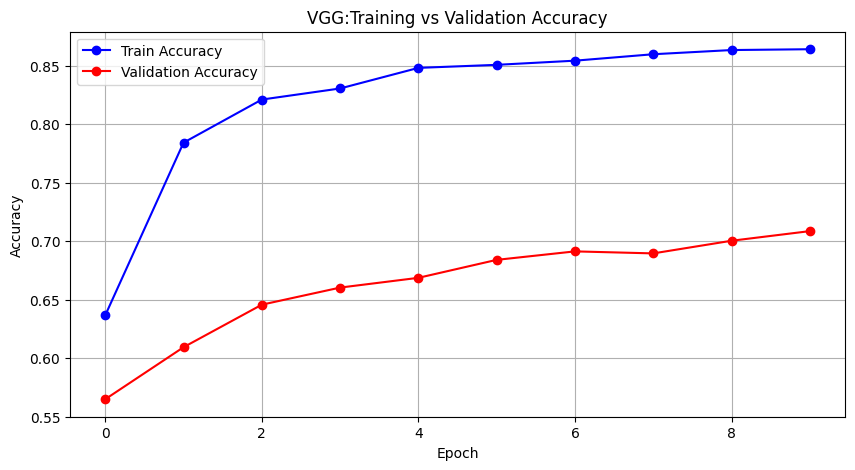

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(vgg_history["train_acc"], label="Train Accuracy", marker='o',color='blue')
plt.plot(vgg_history["val_acc"], label="Validation Accuracy", marker='o',color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG:Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

## **Insights**

- **Fast learning**: Training accuracy rises quickly
- **Validation lags**: Validation improves slower   
- **Overfitting**: ~16% gap between training and validation accuracy.  
- **Plateau**: Validation accuracy stabilizes after ~epoch 6.  


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Load ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Modify the final layer for our number of classes
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(categories))
resnet = resnet.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)

# Checkpoint path
resnet_checkpoint_path = "resnet50_checkpoint.pth"

# Try to resume from checkpoint
start_epoch = 0
best_val_acc = 0.0
if os.path.exists(resnet_checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(resnet_checkpoint_path, map_location=device)
    resnet.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint["best_val_acc"]
    print(f"Resumed from epoch {start_epoch}, best val acc: {best_val_acc:.4f}")

def train_resnet_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    resnet_history = {"resnet_train_loss": [], "resnet_train_acc": [],
                     "resnet_val_loss": [], "resnet_val_acc": []}

    with mlflow.start_run(run_name="ResNet50_TransferLearning", nested=True):
        mlflow.log_params({
            "architecture": "ResNet50",
            "epochs": epochs,
            "optimizer": "Adam",
            "learning_rate": 1e-4,
            "weighted_loss": True,
            "transfer_learning": True
        })

        for epoch in range(start_epoch, epochs):
            model.train()
            running_loss = 0.0
            train_correct = 0
            train_total = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = train_correct / train_total

            resnet_history["resnet_train_loss"].append(epoch_loss)
            resnet_history["resnet_train_acc"].append(epoch_acc)

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss = 0.0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_correct / val_total

            resnet_history["resnet_val_loss"].append(val_loss)
            resnet_history["resnet_val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}]")
            print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            print("-" * 50)

            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_accuracy", epoch_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)

            # Save best model to MLflow
            global best_val_acc
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                mlflow.pytorch.log_state_dict(model.state_dict(), artifact_path="best_resnet50_model")
                print(f"New best model saved with validation accuracy: {val_acc:.4f}")

            #Save checkpoint
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc
            }, resnet_checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

    return model, resnet_history

# Train
resnet, resnet_history = train_resnet_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=10)

print("Training complete")
print(f"Final Training Accuracy: {resnet_history['resnet_train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {resnet_history['resnet_val_acc'][-1]:.4f}")

mlflow.log_metrics({
    "final_train_accuracy": resnet_history['resnet_train_acc'][-1],
    "final_val_accuracy": resnet_history['resnet_val_acc'][-1],
    "best_val_accuracy": max(resnet_history['resnet_val_acc'])})

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 31.9MB/s]
Epoch 1/10: 100%|██████████| 1188/1188 [01:57<00:00, 10.11it/s]


Epoch [1/10]
  Train Loss: 0.8304 | Train Acc: 0.6345
  Val Loss: 0.9373 | Val Acc: 0.6289
--------------------------------------------------
New best model saved with validation accuracy: 0.6289
Checkpoint saved at epoch 1


Epoch 2/10: 100%|██████████| 1188/1188 [01:41<00:00, 11.67it/s]


Epoch [2/10]
  Train Loss: 0.2859 | Train Acc: 0.8548
  Val Loss: 0.7260 | Val Acc: 0.6956
--------------------------------------------------
New best model saved with validation accuracy: 0.6956
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 1188/1188 [01:44<00:00, 11.32it/s]


Epoch [3/10]
  Train Loss: 0.2091 | Train Acc: 0.8848
  Val Loss: 0.6320 | Val Acc: 0.7304
--------------------------------------------------
New best model saved with validation accuracy: 0.7304
Checkpoint saved at epoch 3


Epoch 4/10: 100%|██████████| 1188/1188 [01:40<00:00, 11.80it/s]


Epoch [4/10]
  Train Loss: 0.1707 | Train Acc: 0.9020
  Val Loss: 0.5867 | Val Acc: 0.7465
--------------------------------------------------
New best model saved with validation accuracy: 0.7465
Checkpoint saved at epoch 4


Epoch 5/10: 100%|██████████| 1188/1188 [01:42<00:00, 11.61it/s]


Epoch [5/10]
  Train Loss: 0.1450 | Train Acc: 0.9132
  Val Loss: 0.5234 | Val Acc: 0.7706
--------------------------------------------------
New best model saved with validation accuracy: 0.7706
Checkpoint saved at epoch 5


Epoch 6/10: 100%|██████████| 1188/1188 [01:42<00:00, 11.58it/s]


Epoch [6/10]
  Train Loss: 0.1317 | Train Acc: 0.9210
  Val Loss: 0.4905 | Val Acc: 0.7927
--------------------------------------------------
New best model saved with validation accuracy: 0.7927
Checkpoint saved at epoch 6


Epoch 7/10: 100%|██████████| 1188/1188 [01:46<00:00, 11.21it/s]


Epoch [7/10]
  Train Loss: 0.1183 | Train Acc: 0.9273
  Val Loss: 0.4607 | Val Acc: 0.8014
--------------------------------------------------
New best model saved with validation accuracy: 0.8014
Checkpoint saved at epoch 7


Epoch 8/10: 100%|██████████| 1188/1188 [01:40<00:00, 11.82it/s]


Epoch [8/10]
  Train Loss: 0.1108 | Train Acc: 0.9299
  Val Loss: 0.4783 | Val Acc: 0.8011
--------------------------------------------------
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 1188/1188 [01:40<00:00, 11.81it/s]


Epoch [9/10]
  Train Loss: 0.1062 | Train Acc: 0.9312
  Val Loss: 0.4705 | Val Acc: 0.8014
--------------------------------------------------
Checkpoint saved at epoch 9


Epoch 10/10: 100%|██████████| 1188/1188 [01:41<00:00, 11.75it/s]


Epoch [10/10]
  Train Loss: 0.0968 | Train Acc: 0.9378
  Val Loss: 0.4282 | Val Acc: 0.8139
--------------------------------------------------
New best model saved with validation accuracy: 0.8139
Checkpoint saved at epoch 10
🏃 View run ResNet50_TransferLearning at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/f5a963d479ce4a7ab474a3ce548c1c5c
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
Training complete
Final Training Accuracy: 0.9378
Final Validation Accuracy: 0.8139


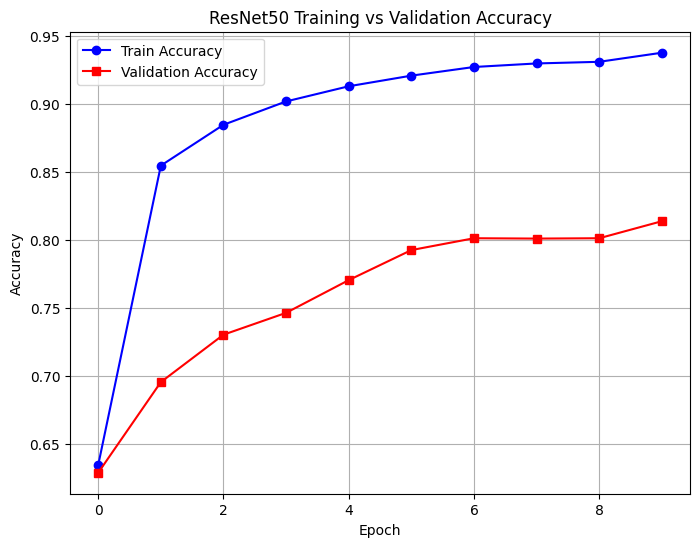

In [35]:
plt.figure(figsize=(8,6))
plt.plot(resnet_history["resnet_train_acc"], label="Train Accuracy", marker='o',color='blue')
plt.plot(resnet_history["resnet_val_acc"], label="Validation Accuracy", marker='s',color='red')
plt.title("ResNet50 Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Insights**

- **Strong learning**: Training accuracy improves quickly.  
- **Validation improves steadily**:showing good generalization.  
- **Moderate gap**:Some overfitting, but less severe than VGG16.  
- **Plateau phase**: Validation accuracy stabilizes after epoch ~6.  
- **Next steps**: Try early stopping, mild regularization, or fine-tuning learning rate for extra gains.  


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained EfficientNet-B0
effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in effnet.features.parameters():
    param.requires_grad = False

# Replace final classifier layer
num_features = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(num_features, len(categories))

# Unfreeze last classifier layer
for param in effnet.classifier[1:].parameters():
    param.requires_grad = True

effnet = effnet.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(effnet.classifier[1:].parameters(), lr=1e-4)

# Checkpoint
efficinetnet_checkpoint_path = "efficientnet_b0_checkpoint.pth"
start_epoch = 0
best_val_acc = 0.0

if os.path.exists(efficinetnet_checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(efficinetnet_checkpoint_path, map_location=device)
    effnet.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint["best_val_acc"]
    print(f"Resumed from epoch {start_epoch}, best val acc: {best_val_acc:.4f}")

def efficient_train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    efficient_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    global best_val_acc
    counter = 0
    with mlflow.start_run(nested=True):
        mlflow.log_param("architecture", "EfficientNet-B0")
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("learning_rate", 1e-4)

        for epoch in range(start_epoch, epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct_train += (preds == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            train_acc = correct_train / len(train_loader.dataset)
            efficient_history["train_loss"].append(epoch_loss)
            efficient_history["train_acc"].append(train_acc)

            # Validation
            model.eval()
            correct_val = 0
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    preds = outputs.argmax(dim=1)
                    correct_val += (preds == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc = correct_val / len(val_loader.dataset)
            efficient_history["val_loss"].append(val_loss)
            efficient_history["val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            mlflow.log_metric("train_loss", epoch_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
                mlflow.pytorch.log_state_dict(model.state_dict(), artifact_path="best_effnet_b0_model")
                print(f" New best model saved with validation accuracy: {val_acc:.4f}")
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

            # Checkpoint
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc
            }, efficinetnet_checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")

    return model, efficient_history

# Train
effnet, efficient_history = efficient_train_model(effnet, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3)
print(" Training complete")

Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]
Epoch 1/10: 100%|██████████| 1188/1188 [01:42<00:00, 11.62it/s]


Epoch [1/10] Train Loss: 1.3602 | Train Acc: 0.5105 | Val Loss: 1.3073 | Val Acc: 0.5555
 New best model saved with validation accuracy: 0.5555
Checkpoint saved at epoch 1


Epoch 2/10: 100%|██████████| 1188/1188 [01:42<00:00, 11.54it/s]


Epoch [2/10] Train Loss: 0.5771 | Train Acc: 0.7559 | Val Loss: 0.8678 | Val Acc: 0.6776
 New best model saved with validation accuracy: 0.6776
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 1188/1188 [01:41<00:00, 11.76it/s]


Epoch [3/10] Train Loss: 0.4066 | Train Acc: 0.8150 | Val Loss: 0.6907 | Val Acc: 0.7296
 New best model saved with validation accuracy: 0.7296
Checkpoint saved at epoch 3


Epoch 4/10: 100%|██████████| 1188/1188 [01:38<00:00, 12.01it/s]


Epoch [4/10] Train Loss: 0.3236 | Train Acc: 0.8452 | Val Loss: 0.5854 | Val Acc: 0.7591
 New best model saved with validation accuracy: 0.7591
Checkpoint saved at epoch 4


Epoch 5/10: 100%|██████████| 1188/1188 [01:33<00:00, 12.75it/s]


Epoch [5/10] Train Loss: 0.2802 | Train Acc: 0.8597 | Val Loss: 0.5189 | Val Acc: 0.7792
 New best model saved with validation accuracy: 0.7792
Checkpoint saved at epoch 5


Epoch 6/10: 100%|██████████| 1188/1188 [01:32<00:00, 12.87it/s]


Epoch [6/10] Train Loss: 0.2519 | Train Acc: 0.8717 | Val Loss: 0.4801 | Val Acc: 0.7908
 New best model saved with validation accuracy: 0.7908
Checkpoint saved at epoch 6


Epoch 7/10: 100%|██████████| 1188/1188 [01:28<00:00, 13.50it/s]


Epoch [7/10] Train Loss: 0.2332 | Train Acc: 0.8795 | Val Loss: 0.4522 | Val Acc: 0.8032
 New best model saved with validation accuracy: 0.8032
Checkpoint saved at epoch 7


Epoch 8/10: 100%|██████████| 1188/1188 [01:28<00:00, 13.48it/s]


Epoch [8/10] Train Loss: 0.2121 | Train Acc: 0.8851 | Val Loss: 0.4177 | Val Acc: 0.8138
 New best model saved with validation accuracy: 0.8138
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 1188/1188 [01:27<00:00, 13.55it/s]


Epoch [9/10] Train Loss: 0.2059 | Train Acc: 0.8897 | Val Loss: 0.3990 | Val Acc: 0.8210
 New best model saved with validation accuracy: 0.8210
Checkpoint saved at epoch 9


Epoch 10/10: 100%|██████████| 1188/1188 [01:27<00:00, 13.64it/s]


Epoch [10/10] Train Loss: 0.1906 | Train Acc: 0.8959 | Val Loss: 0.3801 | Val Acc: 0.8260
 New best model saved with validation accuracy: 0.8260
Checkpoint saved at epoch 10
🏃 View run orderly-deer-645 at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0/runs/0cf3bf18687b441caf4fb098a55e4c7e
🧪 View experiment at: https://dagshub.com/maimohamed201526/plant-disease-project.mlflow/#/experiments/0
 Training complete


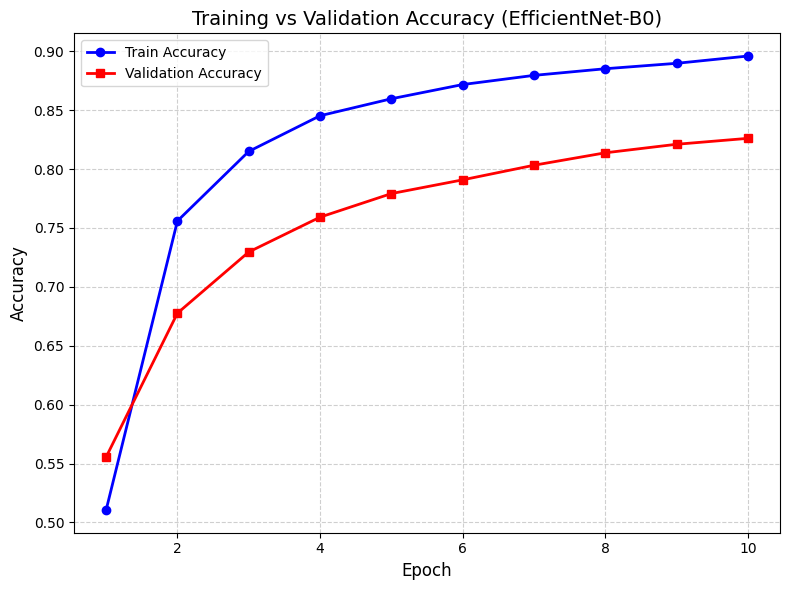

In [37]:
epochs = range(1, len(efficient_history["train_acc"]) + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, efficient_history["train_acc"], label="Train Accuracy", marker='o', color='blue', linewidth=2)
plt.plot(epochs, efficient_history["val_acc"], label="Validation Accuracy", marker='s', color='red', linewidth=2)
plt.title("Training vs Validation Accuracy (EfficientNet-B0)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## **Insights**

- **Steady learning**: Training accuracy improves across epochs.  
- **Validation rises smoothly**:Showing consistent generalization.  
- **Small gap**: The difference between training and validation  is smaller than with VGG16 and ResNet50 : less overfitting.  
- **Good convergence**: Both curves keep improving without strong plateau, suggesting EfficientNet-B0 is learning efficiently.  
- **Next steps**: Could benefit from more epochs or fine-tuning LR schedule; overfitting risk is minimal compared to other models.  
